# Introduction

This notebook is dedicated to face detection in images using YOLOv8.

# Import Libraries

In [10]:
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras_cv import bounding_box
from keras_cv import visualization
import keras_cv
from face_tally.params import *


# Data Acquisition and Exploration

Project Root and Paths

In [11]:
test_image_folder = os.path.join(LOCAL_DATA_PATH, 'raw_data', 'image_data')
path_annot = os.path.join(LOCAL_DATA_PATH, 'bbox_train.csv')


Dataframe Loading and Initial Exploration

In [12]:
df = pd.read_csv(path_annot)
df.head()


,Name,width,height,xmin,ymin,xmax,ymax
0,10001.jpg,612,408,192,199,230,235
1,10001.jpg,612,408,247,168,291,211
2,10001.jpg,612,408,321,176,366,222
3,10001.jpg,612,408,355,183,387,214
4,10002.jpg,612,408,339,165,378,202


# Data Preprocessing

Preprocessing: Convert to REL_XYXY Format, https://keras.io/api/keras_cv/bounding_box/formats/

In [13]:
# Convert to REL_XYXY format
df['LEFT'] = df['xmin'] / df['width'] # LEFT: left of the bounding box
df['TOP'] = df['ymin'] / df['height'] # TOP: top of the bounding box
df['RIGHT'] = df['xmax'] / df['width'] # RIGHT: right of the bounding box
df['BOTTOM'] = df['ymax'] / df['height'] # BOTTOM: bottom of the bounding box

# Selecting only the required columns
df_rel_xyxy = df[['Name', 'LEFT', 'TOP', 'RIGHT', 'BOTTOM']]

#Now we have all columns in the correct format
df_rel_xyxy.head()


,Name,LEFT,TOP,RIGHT,BOTTOM
0,10001.jpg,0.313725,0.487745,0.375817,0.575980
1,10001.jpg,0.403595,0.411765,0.475490,0.517157
2,10001.jpg,0.524510,0.431373,0.598039,0.544118
3,10001.jpg,0.580065,0.448529,0.632353,0.524510
4,10002.jpg,0.553922,0.404412,0.617647,0.495098


# Aggregate Bounding Boxes

In [14]:
# Define a function to aggregate bounding box coordinates for each image.
def aggregate_boxes(data):
    boxes = data[['LEFT', 'TOP', 'RIGHT', 'BOTTOM']].values.tolist()
    return boxes

# Apply the aggregate function to the grouped data and reset the index.
grouped = df_rel_xyxy.groupby('Name').apply(aggregate_boxes).reset_index(name='boxes')
grouped.head()


,Name,boxes
0,10001.jpg,"[[0.3137254901960784, 0.4877450980392157, 0.37..."
1,10002.jpg,"[[0.553921568627451, 0.40441176470588236, 0.61..."
2,10003.jpg,"[[0.08823529411764706, 0.015665796344647518, 0..."
3,10004.jpg,"[[0.22549019607843138, 0.4692874692874693, 0.3..."
4,10006.jpg,"[[0.2875816993464052, 0.3897058823529412, 0.36..."


# Image Paths and Bounding Boxes

In [15]:
image_paths = []
bboxes = []

# Iterate through the grouped dataframe and populate the lists with image paths and bounding boxes.
for _, row in grouped.iterrows():
    image_path = os.path.join(test_image_folder, row['Name'])
    image_bboxes = row['boxes']
    image_paths.append(image_path)
    bboxes.append(image_bboxes)


# Convert to TensorFlow Tensors

In [16]:
# Convert the lists to TensorFlow tensors. Use a ragged tensor for bounding boxes to handle varying lengths.
bbox = tf.ragged.constant(bboxes, dtype=tf.float32)  # Bounding boxes
classes = tf.ragged.constant([[0] * len(b) for b in bboxes], dtype=tf.int32)  # Class labels
image_paths = tf.constant(image_pa      ths)  # Image paths


: 

# Image Loading Function

In [ ]:
# Function to load images without resizing, resize later
def load_image(image_path):
    # Read the image file and decode it to a tensor
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    return image


# Dataset Loading Function

In [ ]:
# Function to create the data dictionary required by KerasCV without resizing the image
def load_dataset(image_path, bbox, classes):
    # Load the image
    image = load_image(image_path)
    # Create a dictionary for bounding boxes with 'boxes' and 'classes' as keys
    bounding_boxes = {'boxes': bbox, 'classes': classes}
    # Return a dictionary with 'images' and 'bounding_boxes'
    return {'images': image, 'bounding_boxes': bounding_boxes}


# Data Combination

In [ ]:
# Create a tf.data.Dataset that combines the image paths with bounding boxes and class labels
data = tf.data.Dataset.from_tensor_slices((image_paths, bbox, classes))


# Data Augmentation

In [ ]:
augmenter = keras.Sequential(
    layers=[
        keras_cv.layers.RandomFlip(mode="horizontal", bounding_box_format="rel_xyxy"),
        keras_cv.layers.RandomShear(
            x_factor=0.2, y_factor=0.2, bounding_box_format="rel_xyxy"
        ),
        keras_cv.layers.JitteredResize(
            target_size=(640, 640), scale_factor=(0.75, 1.3), bounding_box_format="rel_xyxy"
        ),
    ]
)


# Dataset Splitting

In [ ]:
all_images_len = len(set(df.Name))
train_idx = int(all_images_len * 0.8)
validation_idx = int(all_images_len* 0.15)
test_idx = int(all_images_len- train_idx - validation_idx)

train_data = data.take(train_idx)
val_data = data.skip(train_idx).take(validation_idx)
test_data = data.skip(train_idx + validation_idx)


# Training Parameters

In [ ]:
SPLIT_RATIO = 0.2
BATCH_SIZE = 4
LEARNING_RATE = 0.001
EPOCH = 5
GLOBAL_CLIPNORM = 10.0


# Training Dataset Preparation

In [ ]:
train_ds = train_data.map(load_dataset, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.shuffle(BATCH_SIZE * 4)
train_ds = train_ds.ragged_batch(BATCH_SIZE, drop_remainder=True)
train_ds = train_ds.map(augmenter, num_parallel_calls=tf.data.AUTOTUNE)


# Validation Dataset Preparation

In [ ]:
resizing = keras_cv.layers.JitteredResize(
    target_size=(640, 640),
    scale_factor=(0.75, 1.3),
    bounding_box_format="rel_xyxy",
)

val_ds = val_data.map(load_dataset, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.shuffle(BATCH_SIZE * 4)
val_ds = val_ds.ragged_batch(BATCH_SIZE, drop_remainder=True)
val_ds = val_ds.map(resizing, num_parallel_calls=tf.data.AUTOTUNE)


# Class IDs and Mapping

In [ ]:
# Define the class ids and mapping. In this case, we have only one class 'face'.
class_ids = ["face"]
class_mapping = {0: "face"}


# Dataset Visualization

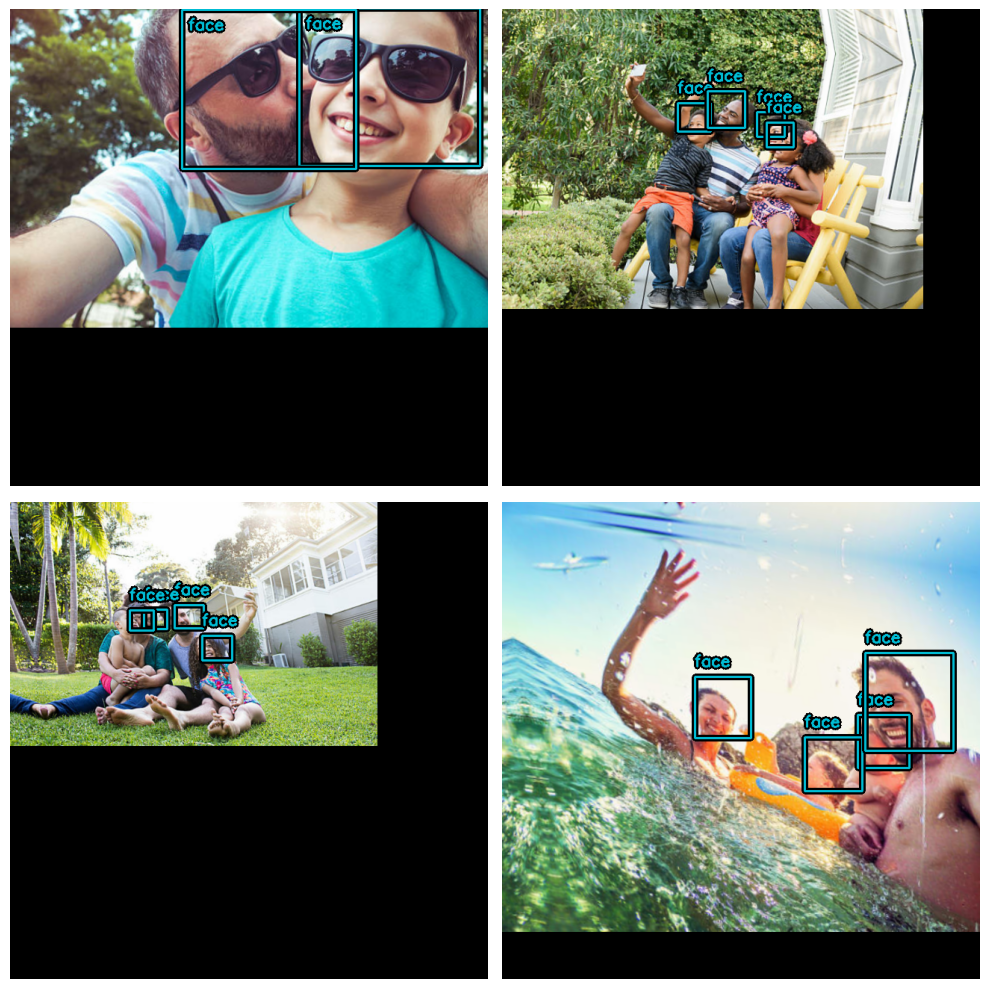

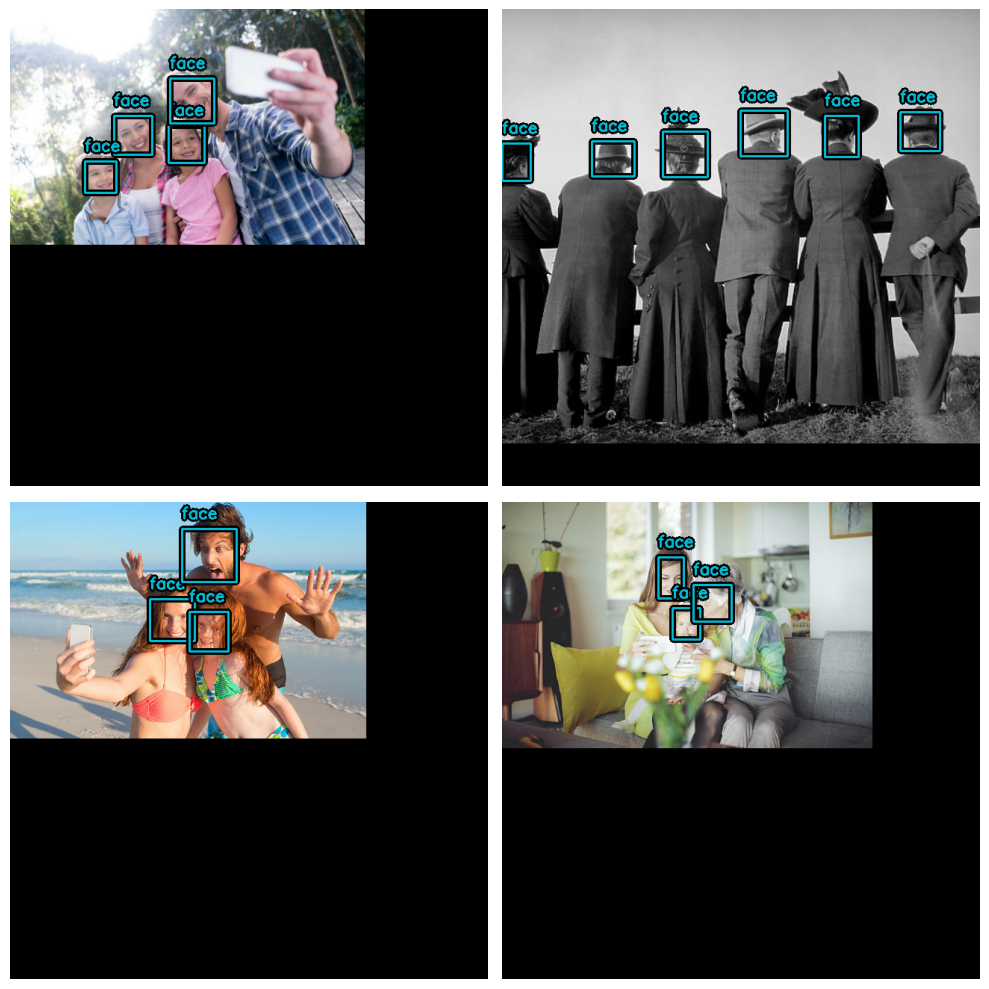

In [ ]:
def visualize_dataset(inputs, value_range, rows, cols, bounding_box_format):
    inputs = next(iter(inputs.take(1)))
    images, bounding_boxes = inputs["images"], inputs["bounding_boxes"]
    visualization.plot_bounding_box_gallery(
        images,
        value_range=value_range,
        rows=rows,
        cols=cols,
        y_true=bounding_boxes,
        scale=5,
        font_scale=0.7,
        bounding_box_format=bounding_box_format,
        class_mapping=class_mapping,
    )


visualize_dataset(
    train_ds, bounding_box_format="rel_xyxy", value_range=(0, 255), rows=2, cols=2
)

visualize_dataset(
    val_ds, bounding_box_format="rel_xyxy", value_range=(0, 255), rows=2, cols=2
)


# Dictionary to Tuple Conversion for Dataset

In [ ]:
def dict_to_tuple(inputs):
    return inputs["images"], inputs["bounding_boxes"]


train_ds = train_ds.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)

val_ds = val_ds.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)
